# Model pipeline
Let's start with our prepared dataset:

In [1]:
import pandas as pd
weather_train_scaled = pd.read_csv('data/weather_train_scaled.csv')

To define a classifier, we need to say what is the input data (`X`) and what is the target (`y`).
For now, we focus on only the numerical features

In [2]:
features = weather_train_scaled.columns[:-1]
print(features)

Index(['BASEL_cloud_cover', 'BASEL_humidity', 'BASEL_pressure',
       'BASEL_global_radiation', 'BASEL_precipitation', 'BASEL_sunshine',
       'BASEL_temp_mean', 'BASEL_temp_min', 'BASEL_temp_max',
       'BUDAPEST_cloud_cover',
       ...
       'STOCKHOLM_temp_min', 'STOCKHOLM_temp_max', 'TOURS_wind_speed',
       'TOURS_humidity', 'TOURS_pressure', 'TOURS_global_radiation',
       'TOURS_precipitation', 'TOURS_temp_mean', 'TOURS_temp_min',
       'TOURS_temp_max'],
      dtype='object', length=163)


In [3]:
X = weather_train_scaled[features]
y = weather_train_scaled['BASEL_BBQ_weather']

We try out a Decision Tree classifier. This classifier tries to find smart splits in the data and assigns a class to every leaf of the tree.

The classifier has several parameters, we leave most of them default but vary the minimal number of samples required to split a node.

In [4]:
from sklearn.tree import DecisionTreeClassifier

In [49]:
# First we define the model and its parameters, in this case the number of neighbors
classifier = DecisionTreeClassifier(min_samples_leaf=2)
# Now we train it on the data
classifier.fit(X, y)

DecisionTreeClassifier()

We can now use our classifier to make predictions:

In [50]:
predictions = classifier.predict(X)
predictions[:10]

array([False, False, False, False, False, False, False, False,  True,
       False])

and compare this with the true target labels, for example using a confusion matrix. The rows in the confusion matrix 
are the true labels and the columns are the predicted labels

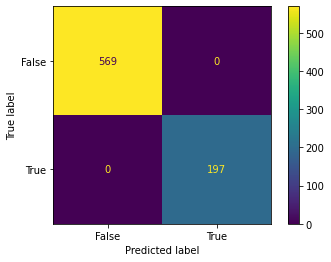

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(classifier, X, y)

### Exercise
Discuss in groups: What do you observe in the confusion matrix? Does the confusion matrix help you decide whether the model will perform well enough on new data?

Answer: The model seems to do very well, the highest values can be found on the diagonal which are correct predictions.
However, we predict on the same data that we trained on. To get a fair estimate of the perfomance, we need to apply it on a new data set, such as the test set

## Pipelines
Ok, suppose we want to predict on our test set. But remember, we also did a data transformation, namely scaling, in the preprocessing phase. We need to do the exact same steps for our test set!

To make it easier to reproduce all steps for new datasets, and to make sure that for each step, the train-test split is well guarded, sklearn provides pipeline. 
So we start again with the unscaled data, but now define a pipeline:

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [23]:
weather_train = pd.read_csv('data/weather_train.csv')
X = weather_train[features]
y = weather_train['BASEL_BBQ_weather']

In [40]:
# We give the pipeline tuples of step names, and step objects
pipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('model', DecisionTreeClassifier())
])

In [41]:
pipe.fit(X, y)

Pipeline(steps=[('scale', MinMaxScaler()), ('model', DecisionTreeClassifier())])

To now test in on our test set: (note that we still have to drop null values)

In [42]:
weather_test = pd.read_csv('data/weather_test.csv')
X_test = weather_test[features]
y_test = weather_test['BASEL_BBQ_weather']

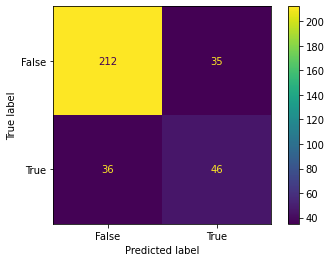

In [43]:
ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)

It seems that the confusion matrix is worse than the one on the train set, but it is difficult to draw this conclusion from the confusion matrix alone. It would be nice to have one score that expresses how well our model does.

We calculate *accuracy*: this is the number of correctly labeled instances, divided the total number of instances. Note that this score works well when we have a balanced dataset (similar number of instances per class) but if we have imbalanced class, the majority class can dominate the score.

In [44]:
from sklearn.metrics import accuracy_score

In [45]:
pred_test = pipe.predict(X_test)
print('Train accuracy:', accuracy_score(y, predictions))
print('Test accuracy:', accuracy_score(y_test, pred_test))

Train accuracy: 0.97911227154047
Test accuracy: 0.7872340425531915


But what is our accuracy if we always predict `False` (which is the majority class)?

In [46]:
accuracy_score(y_test, [False]*len(y_test))

0.7507598784194529

So it turns out our model does not perform so well in real life afer all..
This is called 'overfitting'

**Exercise** Thinking back at the theory on decision trees, what approaches could we take to prevent overfitting?

**Answer**: If we don't limit the size of the tree, the algorithm could create a tree that exactly fits our training data, and each data point will have its own leaf in the tree. However, such a model does not generalize to other data, and will perform worse on unseen data. By restricting how specific the tree can fit the data, for example by limiting its size, we may generalize better over other data. 

In [47]:
tree_model = pipe.named_steps['model']
tree_model

DecisionTreeClassifier()

In [48]:
tree_model.get_depth()

15